<a href="https://colab.research.google.com/github/stevejj4/Data-Cleaning/blob/main/SUN_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
from google.colab import auth
import gspread
from google.auth import default

# Authorize Google Colab
auth.authenticate_user()

# Credentials for Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

# Load the Google Sheet
spreadsheet = gc.open('SUN_Dashboard')

# Check if the sheet 'transformed' exists and create it if not
try:
    transformed_sheet = spreadsheet.worksheet('transformed')
except gspread.exceptions.WorksheetNotFound:
    transformed_sheet = spreadsheet.add_worksheet(title='transformed', rows="1000", cols="20")

# Load the original data
worksheet = spreadsheet.sheet1
rows = worksheet.get_all_values()

# Create DataFrame from the sheet data
df = pd.DataFrame(rows)
df.columns = df.iloc[0]  # Set the first row as column names
df = df.iloc[1:]  # Remove the first row


In [15]:
df.shape

(68, 24)

In [16]:
# Reshape the data from wide to long format
value_vars = ['Contribution', 'Compensation', 'Deaths']
months = ['January', 'February', 'March', 'April', 'May', 'June']

# Initialize an empty list to store the reshaped data
reshaped_data = []

# Iterate through each row in the DataFrame
for _, row in df.iterrows():
    for month in months:
        reshaped_data.append({
            'PAYBILL NO': row['PAYBILL NO'],
            'SUB COUNTY': row['SUB COUNTY'],
            'REGION': row['REGION'],
            'Cluster': row['Cluster'],
            'County': row['County'],
            'Site': row['Site'],
            'Month': month,
            'Contribution': row[f'{month}_Contribution'],
            'Compensation': row[f'{month}_Compensation'],
            'Deaths_per_Month': row[f'{month}_deaths']
        })

# Create a new DataFrame from the reshaped data
reshaped_df = pd.DataFrame(reshaped_data)

# Convert the DataFrame to a list of lists
reshaped_data_list = [reshaped_df.columns.values.tolist()] + reshaped_df.values.tolist()

# Clear the 'transformed' sheet
transformed_sheet.clear()

# Write the reshaped DataFrame to the 'transformed' sheet
transformed_sheet.update('A1', reshaped_data_list)

# Print confirmation
print('Data successfully loaded into the transformed sheet.')


<ipython-input-16-7fa8ac9f1670>:34: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  transformed_sheet.update('A1', reshaped_data_list)


Data successfully loaded into the transformed sheet.


In [17]:
# Select the sheet named 'transformed'
worksheet = spreadsheet.worksheet('transformed')

# Get all the values from the sheet
rows = worksheet.get_all_values()

# Convert the data to a pandas DataFrame
df = pd.DataFrame(rows)

# Set the first row as the header
df.columns = df.iloc[0]
df = df.drop(0)

In [18]:
#cheking the data type
df.dtypes

0
PAYBILL NO          object
SUB COUNTY          object
REGION              object
Cluster             object
County              object
Site                object
Month               object
Contribution        object
Compensation        object
Deaths_per_Month    object
dtype: object

In [19]:
# Check if there maybe any missing data
df.isnull().sum()

0
PAYBILL NO          0
SUB COUNTY          0
REGION              0
Cluster             0
County              0
Site                0
Month               0
Contribution        0
Compensation        0
Deaths_per_Month    0
dtype: int64

In [20]:
# Remove commas from the numeric columns and convert to float
df['Contribution'] = df['Contribution'].astype(str).str.replace(',', '').astype(float)
df['Compensation'] = df['Compensation'].astype(str).str.replace(',', '').astype(float)
df['Deaths_per_Month'] = df['Deaths_per_Month'].astype(str).str.replace(',', '').astype(float)

# Inspect the cleaned data
#df.dtypes

## Explanatory data analysis(EDA)
The graphical exploration/ representation of data (1977, John Turkey). From this we are able to form hypothesess for our data for further analyses or study
‘Exploratory data analysis’ is an attitude, a state of flexibility, a willingness to look for those things that we believe are not there, as well as those we believe to be there.”

In [21]:
# “Graphs force us to note the unexpected; nothing could be more important.”
#Lets start by analyzing the monthly trends for contributions, compensation amounts and the number of deaths
#Converting the Month column to a categorical type with a proper order
# Assuming transformed_data is your DataFrame



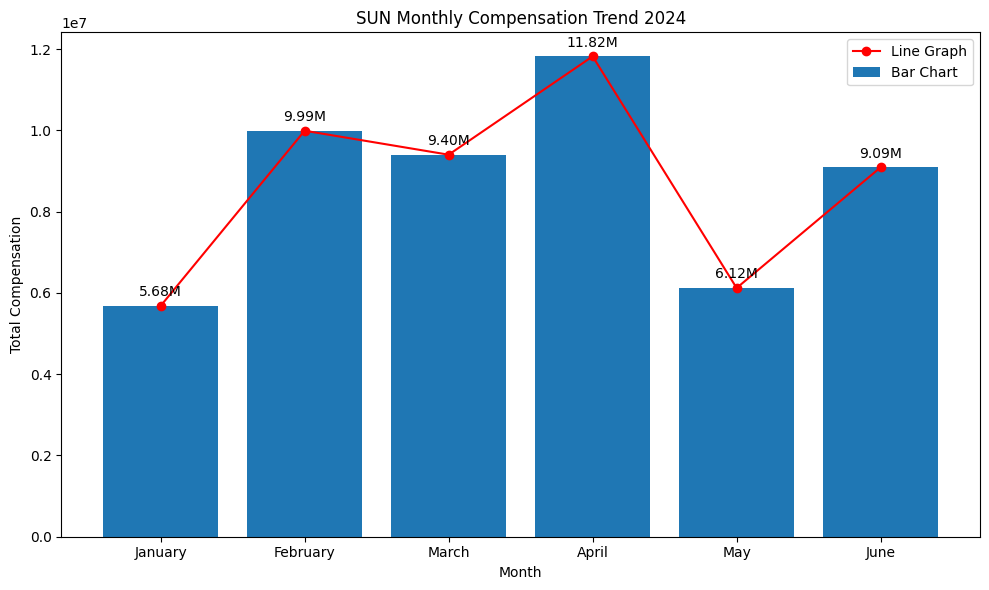

In [22]:
import matplotlib.pyplot as plt

# Group the data by month and calculate the total compensation for each month
monthly_compensation = df.groupby('Month')['Compensation'].sum()

# Ensure months are in the correct order (January to May)
month_order = ['January', 'February', 'March', 'April', 'May', 'June']
monthly_compensation = monthly_compensation.reindex(month_order)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart
ax.bar(monthly_compensation.index, monthly_compensation.values, label='Bar Chart')

# Plot the line graph
ax.plot(monthly_compensation.index, monthly_compensation.values, marker='o', color='red', label='Line Graph')

# Set the title and labels
ax.set_title('SUN Monthly Compensation Trend 2024')
ax.set_xlabel('Month')
ax.set_ylabel('Total Compensation')

# Add labels above each bar/point with 'M' to indicate millions
for x, y in zip(monthly_compensation.index, monthly_compensation.values):
    ax.annotate(f'{y/1_000_000:.2f}M', (x, y), textcoords="offset points", xytext=(0,7), ha='center')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

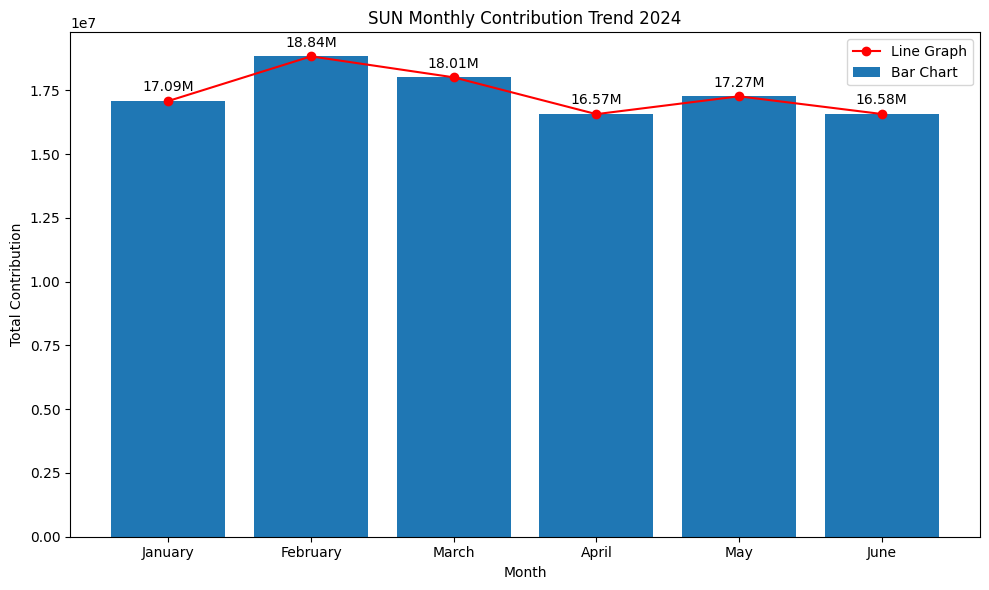

In [23]:
# Group the data by month and calculate the total contributions for each month
monthly_Contribution = df.groupby('Month')['Contribution'].sum()

# Ensure months are in the correct order (January to May)
month_order = ['January', 'February', 'March', 'April', 'May', 'June']
monthly_Contribution = monthly_Contribution.reindex(month_order)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart
ax.bar(monthly_Contribution.index, monthly_Contribution.values, label='Bar Chart')

# Plot the line graph
ax.plot(monthly_Contribution.index, monthly_Contribution.values, marker='o', color='red', label='Line Graph')

# Set the title and labels
ax.set_title('SUN Monthly Contribution Trend 2024')
ax.set_xlabel('Month')
ax.set_ylabel('Total Contribution')

# Add labels above each bar/point with 'M' to indicate millions
for x, y in zip(monthly_Contribution.index, monthly_Contribution.values):
    ax.annotate(f'{y/1_000_000:.2f}M', (x, y), textcoords="offset points", xytext=(0,7), ha='center')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

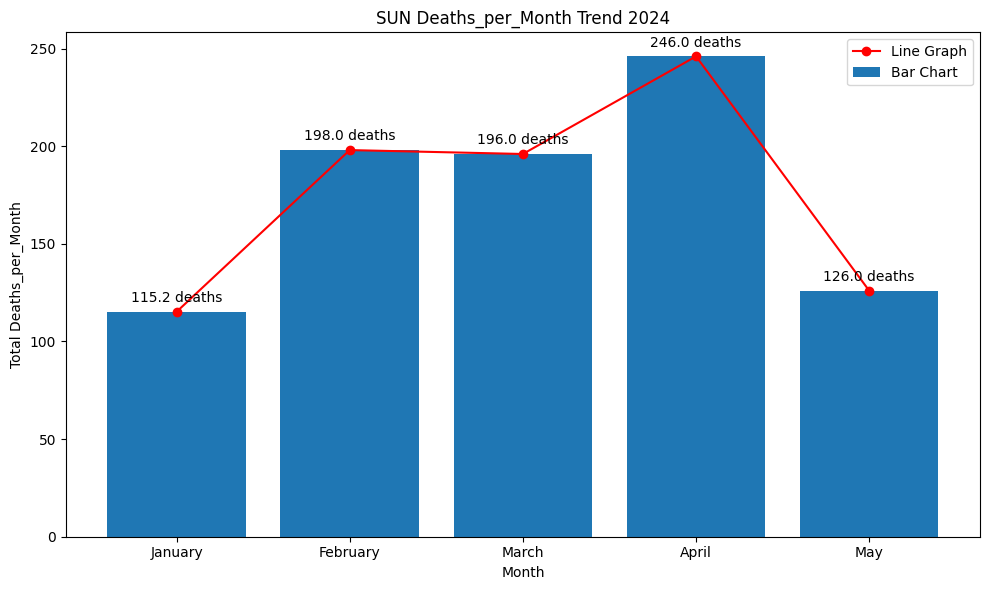

In [24]:
# Group the data by month and calculate the total deaths for each month
monthly_Deaths_per_Month = df.groupby('Month')['Deaths_per_Month'].sum()

# Ensure months are in the correct order (January to May)
month_order = ['January', 'February', 'March', 'April', 'May']
monthly_Deaths_per_Month = monthly_Deaths_per_Month.reindex(month_order)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart
ax.bar(monthly_Deaths_per_Month.index, monthly_Deaths_per_Month.values, label='Bar Chart')

# Plot the line graph
ax.plot(monthly_Deaths_per_Month.index, monthly_Deaths_per_Month.values, marker='o', color='red', label='Line Graph')

# Set the title and labels
ax.set_title('SUN Deaths_per_Month Trend 2024')
ax.set_xlabel('Month')
ax.set_ylabel('Total Deaths_per_Month')

# Add labels above each bar/point with 'M' to indicate millions
for x, y in zip(monthly_Deaths_per_Month.index, monthly_Deaths_per_Month.values):
    ax.annotate(f'{y/1} deaths', (x, y), textcoords="offset points", xytext=(0,7), ha='center')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
monthly_Deaths_per_Month.T

Month
January     115.2
February    198.0
March       196.0
April       246.0
May         126.0
Name: Deaths_per_Month, dtype: float64

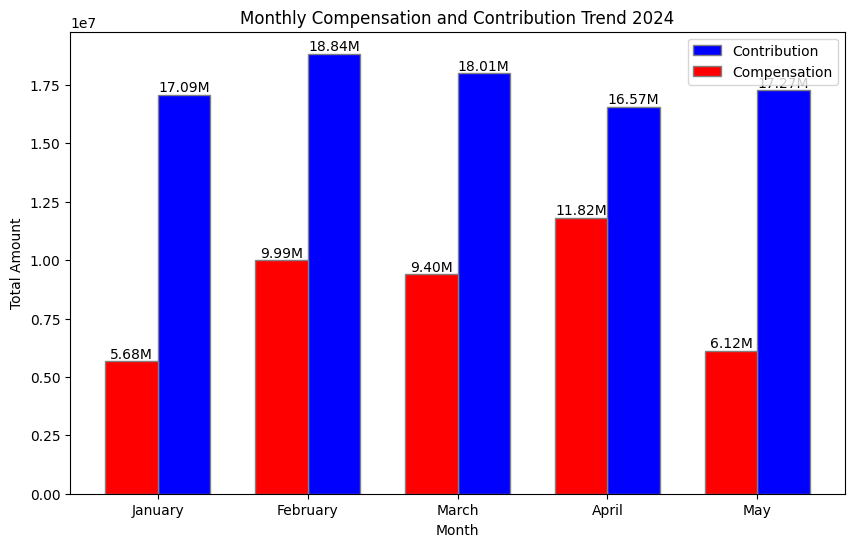

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Group the data by month and calculate the total compensation and contribution for each month
monthly_compensation = df.groupby('Month')['Compensation'].sum()
monthly_contribution = df.groupby('Month')['Contribution'].sum()

# Ensure months are in the correct order (January to May)
month_order = ['January', 'February', 'March', 'April', 'May']
monthly_compensation = monthly_compensation.reindex(month_order)
monthly_contribution = monthly_contribution.reindex(month_order)

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(monthly_compensation))
r2 = [x + bar_width for x in r1]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(r2, monthly_contribution.values, color='blue', width=bar_width, edgecolor='grey', label='Contribution')
bars2 = ax.bar(r1, monthly_compensation.values, color='red', width=bar_width, edgecolor='grey', label='Compensation')


# Add labels, title, and legend
ax.set_xlabel('Month')
ax.set_ylabel('Total Amount')
ax.set_title('Monthly Compensation and Contribution Trend 2024')
ax.set_xticks([r + bar_width/2 for r in range(len(monthly_compensation))])
ax.set_xticklabels(monthly_compensation.index)
ax.legend()

# Add labels on top of each bar
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval/1_000_000:.2f}M', ha='center', va='bottom')

# Display the plot
plt.show()